In [ ]:
#
# This is a sample Notebook to demonstrate how to read "MNIST_Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '../MNIST_Dataset'
training_images_filepath = join("MNIST_Dataset/train-images-idx3-ubyte/train-images-idx3-ubyte")
training_labels_filepath = join("MNIST_Dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte")
test_images_filepath = join("MNIST_Dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels_filepath = join("MNIST_Dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)


In [ ]:
import numpy as np

class PCAFromScratch:
    def __init__(self, n_components, normalization='column'):
        """
        Args:
            n_components: Number of principal components to keep
            normalization: 'column' (per-feature) or 'full' (global)
        """
        self.n_components = n_components
        self.normalization = normalization
        self.components_ = None
        self.mean_ = None
        self.std_ = None
        self.global_mean_ = None
        self.global_std_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        """
        Fit PCA on data X
        """
        if self.normalization == 'full':
            # Full normalization: single mean and std for entire dataset
            self.global_mean_ = np.mean(X)
            self.global_std_ = np.std(X)
            X_normalized = (X - self.global_mean_) / self.global_std_
        else:
            # Column-wise normalization (original behavior)
            self.mean_ = np.mean(X, axis=0)
            X_normalized = X - self.mean_

        cov_matrix = np.cov(X_normalized.T)

        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        self.components_ = eigenvectors[:, :self.n_components].T

        self.explained_variance_ratio_ = eigenvalues[:self.n_components] / np.sum(eigenvalues)

        return self

    def transform(self, X):
        """
        Transform data to PCA space
        """
        if self.normalization == 'full':
            X_normalized = (X - self.global_mean_) / self.global_std_
        else:
            X_normalized = X - self.mean_

        return np.dot(X_normalized, self.components_.T)

    def inverse_transform(self, X_transformed):
        """
        Transform data back to original space
        """
        X_reconstructed = np.dot(X_transformed, self.components_)

        if self.normalization == 'full':
            return X_reconstructed * self.global_std_ + self.global_mean_
        else:
            return X_reconstructed + self.mean_

    def fit_transform(self, X):
        """
        Fit PCA and transform data
        """
        return self.fit(X).transform(X)

def pca_compress_images_scratch(images, n_components, normalization='column'):
    """
    Compress images using PCA from scratch

    Args:
        images: List of images (28x28 arrays)
        n_components: Number of principal components to keep
        normalization: 'column' or 'full'

    Returns:
        compressed_images: List of compressed and reconstructed images
        compression_ratio: Compression ratio achieved
        pca: PCA object with learned components
    """
    # Convert to numpy arrays and flatten images to 1D vectors
    flattened_images = []
    for img in images:
        if isinstance(img, list):
            img_array = np.array(img)
            flattened_images.append(img_array.flatten())
        else:
            flattened_images.append(img.flatten())

    flattened_images = np.array(flattened_images)

    pca = PCAFromScratch(n_components=n_components, normalization=normalization)
    compressed_data = pca.fit_transform(flattened_images)

    reconstructed_data = pca.inverse_transform(compressed_data)

    reconstructed_images = [data.reshape(28, 28) for data in reconstructed_data]

    original_size = 28 * 28
    compressed_size = n_components
    compression_ratio = original_size / compressed_size

    return reconstructed_images, compression_ratio, pca

test_images = x_train[:100]
component_counts = [10, 25, 50, 100, 200]

print("Comparison: Column vs Full Normalization")
print("=" * 60)

for n_comp in component_counts:
    # Column normalization
    _, ratio_col, pca_col = pca_compress_images_scratch(test_images, n_comp, 'column')
    variance_col = np.sum(pca_col.explained_variance_ratio_)

    # Full normalization
    _, ratio_full, pca_full = pca_compress_images_scratch(test_images, n_comp, 'full')
    variance_full = np.sum(pca_full.explained_variance_ratio_)
    
    print(f"Components: {n_comp:3d}")
    print(f"  Column: Variance = {variance_col:.3f}")
    print(f"  Full:   Variance = {variance_full:.3f}")
    print()

Comparison with FULL normalization:


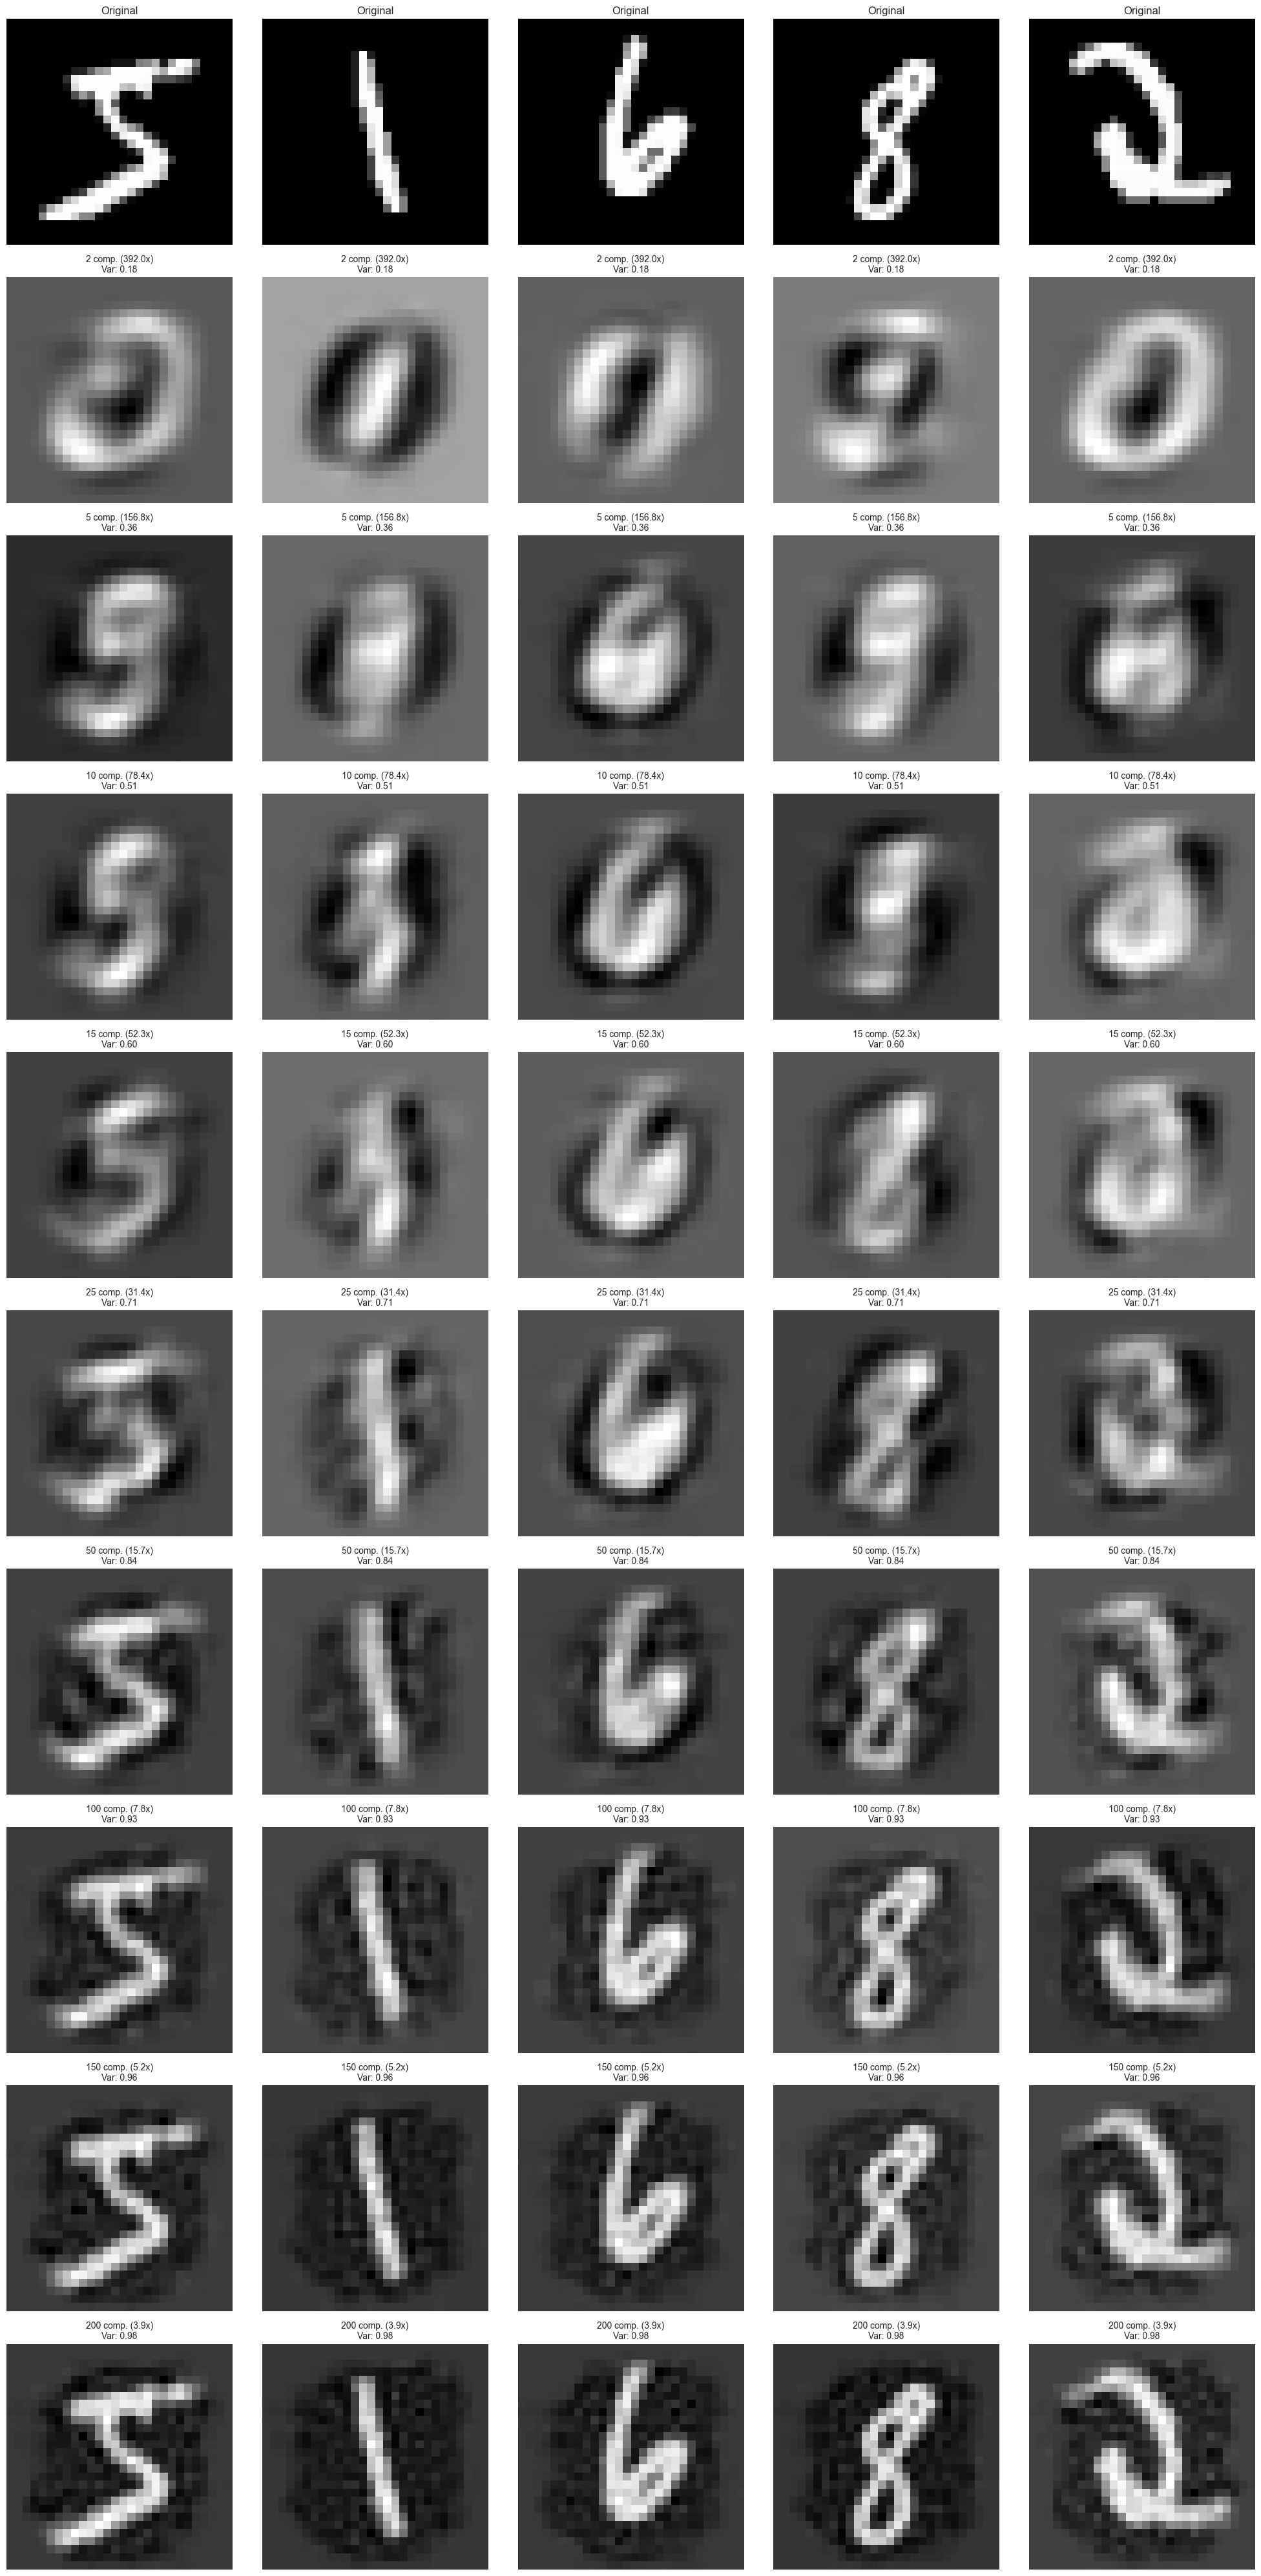


Comparison with COLUMN normalization (original):


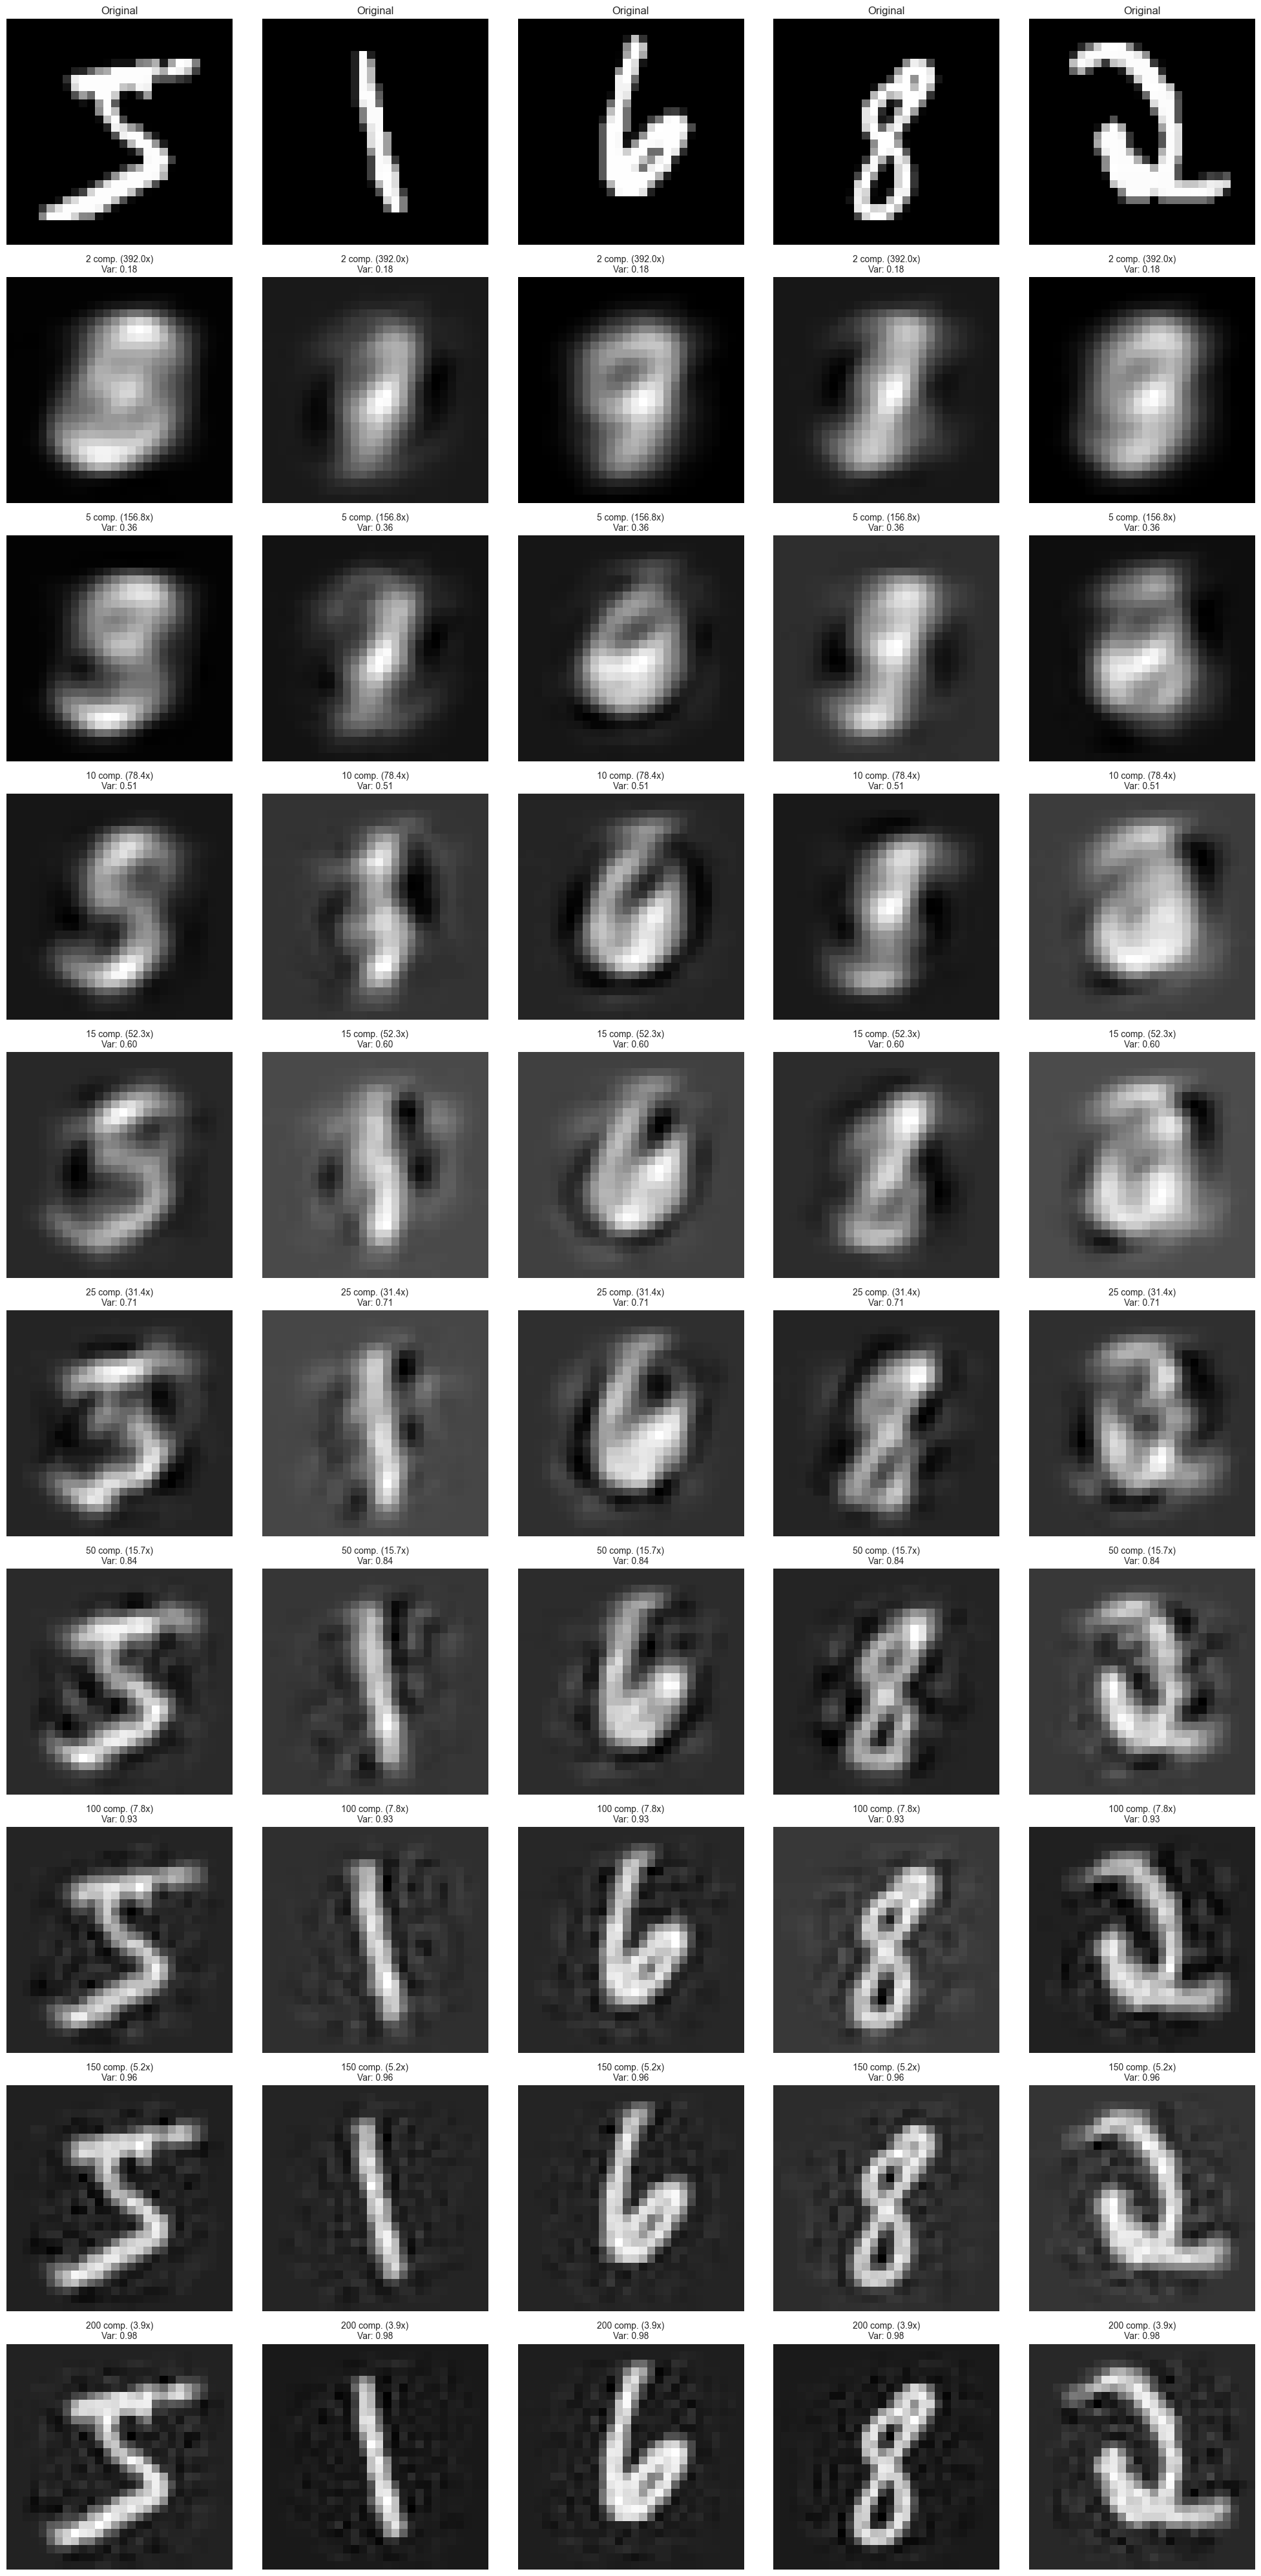

In [3]:
def show_compression_comparison_scratch(original_images, component_counts, num_examples=5, normalization='column'):
    """
    Show side-by-side comparison of original and compressed images using PCA from scratch
    Uses separate training set for PCA to show real compression effects
    """
    fig, axes = plt.subplots(len(component_counts) + 1, num_examples, figsize=(20, 4 * (len(component_counts) + 1)))
    
    for i in range(num_examples):
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].set_title(f'Original', fontsize=12)
        axes[0, i].axis('off')
    
    for row, n_comp in enumerate(component_counts, 1):
        compressed_imgs, ratio, pca_obj = pca_compress_images_scratch(original_images, n_comp, normalization=normalization, use_separate_training=True)
        variance_explained = np.sum(pca_obj.explained_variance_ratio_)
        
        for i in range(num_examples):
            axes[row, i].imshow(compressed_imgs[i], cmap='gray')
            axes[row, i].set_title(f'{n_comp} comp. ({ratio:.1f}x)\nVar: {variance_explained:.2f}', fontsize=10)
            axes[row, i].axis('off')
    
    plt.tight_layout()
    plt.show()

def pca_compress_images_scratch(images, n_components, normalization='column', use_separate_training=False):
    """
    Compress images using PCA from scratch with option to use separate training set
    
    Args:
        images: Images to compress and reconstruct
        n_components: Number of principal components to keep
        normalization: 'column' or 'full'
        use_separate_training: If True, uses separate training images for PCA
    
    Returns:
        compressed_images: List of compressed and reconstructed images
        compression_ratio: Compression ratio achieved
        pca: PCA object with learned components
    """
    if use_separate_training:
        training_images = x_train[1000:2000]
        
        flattened_training = []
        for img in training_images:
            if isinstance(img, list):
                img_array = np.array(img)
                flattened_training.append(img_array.flatten())
            else:
                flattened_training.append(img.flatten())
        
        flattened_training = np.array(flattened_training)
        
        pca = PCAFromScratch(n_components=n_components, normalization=normalization)
        pca.fit(flattened_training)
        
        flattened_test = []
        for img in images:
            if isinstance(img, list):
                img_array = np.array(img)
                flattened_test.append(img_array.flatten())
            else:
                flattened_test.append(img.flatten())
        
        flattened_test = np.array(flattened_test)
        
        compressed_data = pca.transform(flattened_test)
        reconstructed_data = pca.inverse_transform(compressed_data)
        
    else:
        flattened_images = []
        for img in images:
            if isinstance(img, list):
                img_array = np.array(img)
                flattened_images.append(img_array.flatten())
            else:
                flattened_images.append(img.flatten())
        
        flattened_images = np.array(flattened_images)
        
        pca = PCAFromScratch(n_components=n_components, normalization=normalization)
        compressed_data = pca.fit_transform(flattened_images)
        reconstructed_data = pca.inverse_transform(compressed_data)
    
    reconstructed_images = [data.reshape(28, 28) for data in reconstructed_data]
    
    original_size = 28 * 28
    compressed_size = n_components
    compression_ratio = original_size / compressed_size
    
    return reconstructed_images, compression_ratio, pca

sample_images = [x_train[i] for i in [0, 104, 204, 300, 400]]
comparison_components = [2, 5, 10, 15, 25, 50, 100, 150, 200]

print("Comparison with FULL normalization:")
show_compression_comparison_scratch(sample_images, comparison_components, normalization='full')

print("\nComparison with COLUMN normalization (original):")
show_compression_comparison_scratch(sample_images, comparison_components, normalization='column')

Analyzing PCA compression quality ...


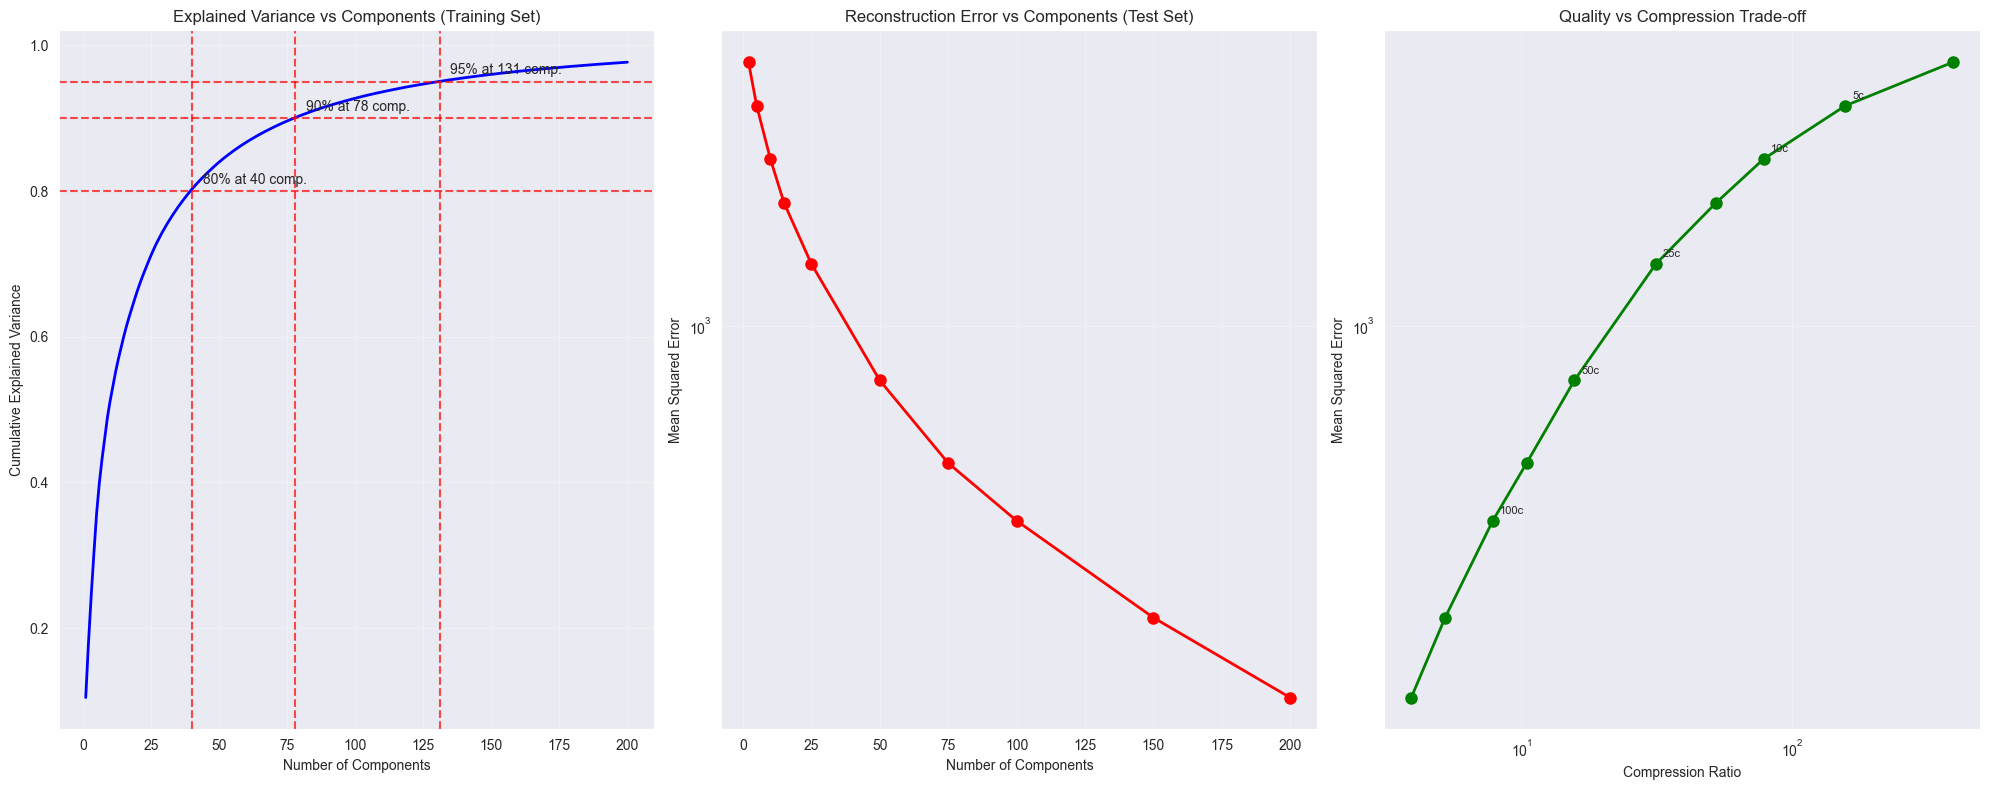


Compression Analysis Summary:
Training set variance explained:
    80% variance:  40 components (compression: 19.6x)
    90% variance:  78 components (compression: 10.1x)
    95% variance: 131 components (compression: 6.0x)
    99% variance: Not achievable with 200 components

Key statistics:
  First 10 components explain 0.513 of training variance
  First 50 components explain 0.840 of training variance

Test set reconstruction errors:
    2 components: MSE = 3.36e+03, Compression = 392.0x
    5 components: MSE = 2.75e+03, Compression = 156.8x
   10 components: MSE = 2.15e+03, Compression = 78.4x
   15 components: MSE = 1.76e+03, Compression = 52.3x
   25 components: MSE = 1.33e+03, Compression = 31.4x
   50 components: MSE = 7.78e+02, Compression = 15.7x
   75 components: MSE = 5.33e+02, Compression = 10.5x
  100 components: MSE = 4.09e+02, Compression = 7.8x
  150 components: MSE = 2.62e+02, Compression = 5.2x
  200 components: MSE = 1.81e+02, Compression = 3.9x


In [4]:
def analyze_compression_quality_scratch(images, max_components=200):
    """
    Analyze compression quality vs number of components using PCA from scratch
    Uses separate training/test sets for realistic evaluation
    """
    training_images = x_train[1000:2000]
    test_images = images[:500]
    
    flattened_training = []
    for img in training_images:
        if isinstance(img, list):
            img_array = np.array(img)
            flattened_training.append(img_array.flatten())
        else:
            flattened_training.append(img.flatten())
    
    flattened_training = np.array(flattened_training)
    
    pca = PCAFromScratch(n_components=max_components)
    pca.fit(flattened_training)
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(1, 3, 1)
    plt.plot(range(1, max_components + 1), cumulative_variance, 'b-', linewidth=2)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs Components (Training Set)')
    plt.grid(True, alpha=0.3)
    
    for variance in [0.8, 0.9, 0.95]:
        idx = np.where(cumulative_variance >= variance)[0]
        if len(idx) > 0:
            idx = idx[0]
            plt.axhline(y=variance, color='r', linestyle='--', alpha=0.7)
            plt.axvline(x=idx+1, color='r', linestyle='--', alpha=0.7)
            plt.text(idx+5, variance+0.01, f'{variance*100:.0f}% at {idx+1} comp.', fontsize=10)
    
    plt.subplot(1, 3, 2)
    components_range = [2, 5, 10, 15, 25, 50, 75, 100, 150, 200]
    reconstruction_errors = []
    
    for n_comp in components_range:
        if n_comp <= max_components:
            compressed_imgs, _, _ = pca_compress_images_scratch(test_images[:50], n_comp, use_separate_training=True)
            
            mse_values = []
            for orig, comp in zip(test_images[:50], compressed_imgs):
                if isinstance(orig, list):
                    orig = np.array(orig)
                mse_values.append(np.mean((orig - comp)**2))
            
            mse = np.mean(mse_values)
            reconstruction_errors.append(mse)
        else:
            reconstruction_errors.append(np.nan)
    
    valid_indices = [i for i, x in enumerate(reconstruction_errors) if not np.isnan(x)]
    valid_components = [components_range[i] for i in valid_indices]
    valid_errors = [reconstruction_errors[i] for i in valid_indices]
    
    plt.plot(valid_components, valid_errors, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('Number of Components')
    plt.ylabel('Mean Squared Error')
    plt.title('Reconstruction Error vs Components (Test Set)')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.subplot(1, 3, 3)
    compression_ratios = [784 / n_comp for n_comp in valid_components]
    plt.plot(compression_ratios, valid_errors, 'go-', linewidth=2, markersize=8)
    plt.xlabel('Compression Ratio')
    plt.ylabel('Mean Squared Error')
    plt.title('Quality vs Compression Trade-off')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.xscale('log')
    
    for i, (ratio, error, comp) in enumerate(zip(compression_ratios, valid_errors, valid_components)):
        if comp in [5, 10, 25, 50, 100]:
            plt.annotate(f'{comp}c', (ratio, error), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("\nCompression Analysis Summary:")
    print("=" * 70)
    print("Training set variance explained:")
    for variance in [0.8, 0.9, 0.95, 0.99]:
        idx = np.where(cumulative_variance >= variance)[0]
        if len(idx) > 0:
            idx = idx[0] + 1
            compression_ratio = 784 / idx
            print(f"  {variance*100:4.0f}% variance: {idx:3d} components (compression: {compression_ratio:.1f}x)")
        else:
            print(f"  {variance*100:4.0f}% variance: Not achievable with {max_components} components")
    
    print(f"\nKey statistics:")
    print(f"  First 10 components explain {cumulative_variance[9]:.3f} of training variance")
    print(f"  First 50 components explain {cumulative_variance[49]:.3f} of training variance")
    
    print(f"\nTest set reconstruction errors:")
    for comp, error in zip(valid_components, valid_errors):
        compression_ratio = 784 / comp
        print(f"  {comp:3d} components: MSE = {error:.2e}, Compression = {compression_ratio:.1f}x")

print("Analyzing PCA compression quality ...")
analyze_compression_quality_scratch(x_train[:1000])

## compression + decompression

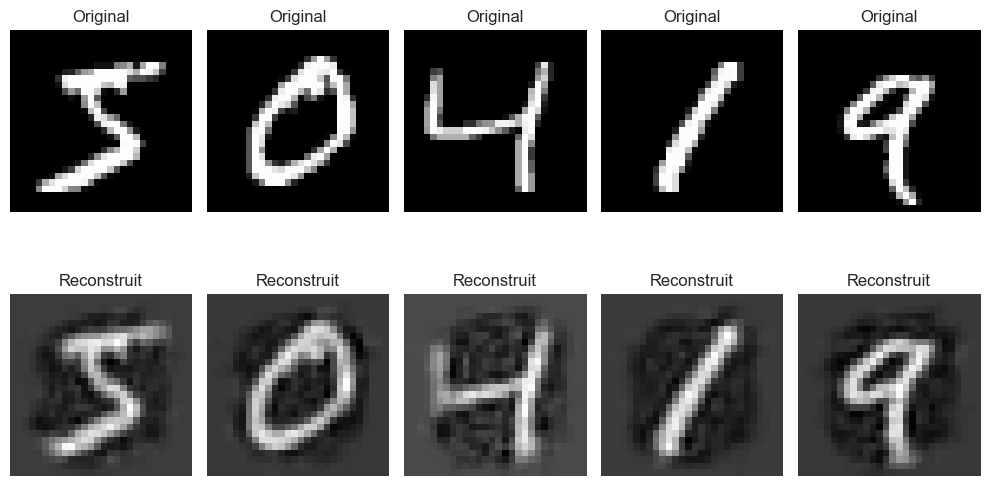

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def compress_and_decompress_images(test_images, training_images, n_components):
    X_train = np.array([img.flatten() for img in training_images])
    X_test = np.array([img.flatten() for img in test_images])

    pca = PCAFromScratch(n_components=n_components, normalization='full')
    pca.fit(X_train)

    compressed = pca.transform(X_test)

    decompressed = pca.inverse_transform(compressed)

    compressed_shapes = compressed
    reconstructed_images = [vec.reshape(28, 28) for vec in decompressed]

    return compressed_shapes, reconstructed_images

def show_compression_pipeline(original_images, training_images, n_components):
    compressed_data, reconstructed_images = compress_and_decompress_images(
        original_images, training_images, n_components
    )

    num_examples = len(original_images)
    fig, axes = plt.subplots(2, num_examples, figsize=(2 * num_examples, 6))

    for i in range(num_examples):
        axes[0, i].imshow(original_images[i], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')


        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].set_title("Reconstruit")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


(x_train, _), (_, _) = mnist.load_data()

test_samples = [x_train[i] for i in [0, 1, 2, 3, 4]]
training_samples = x_train[1000:2000]

show_compression_pipeline(test_samples, training_samples, n_components=100)

## projection

=== FULL NORMALIZATION ===


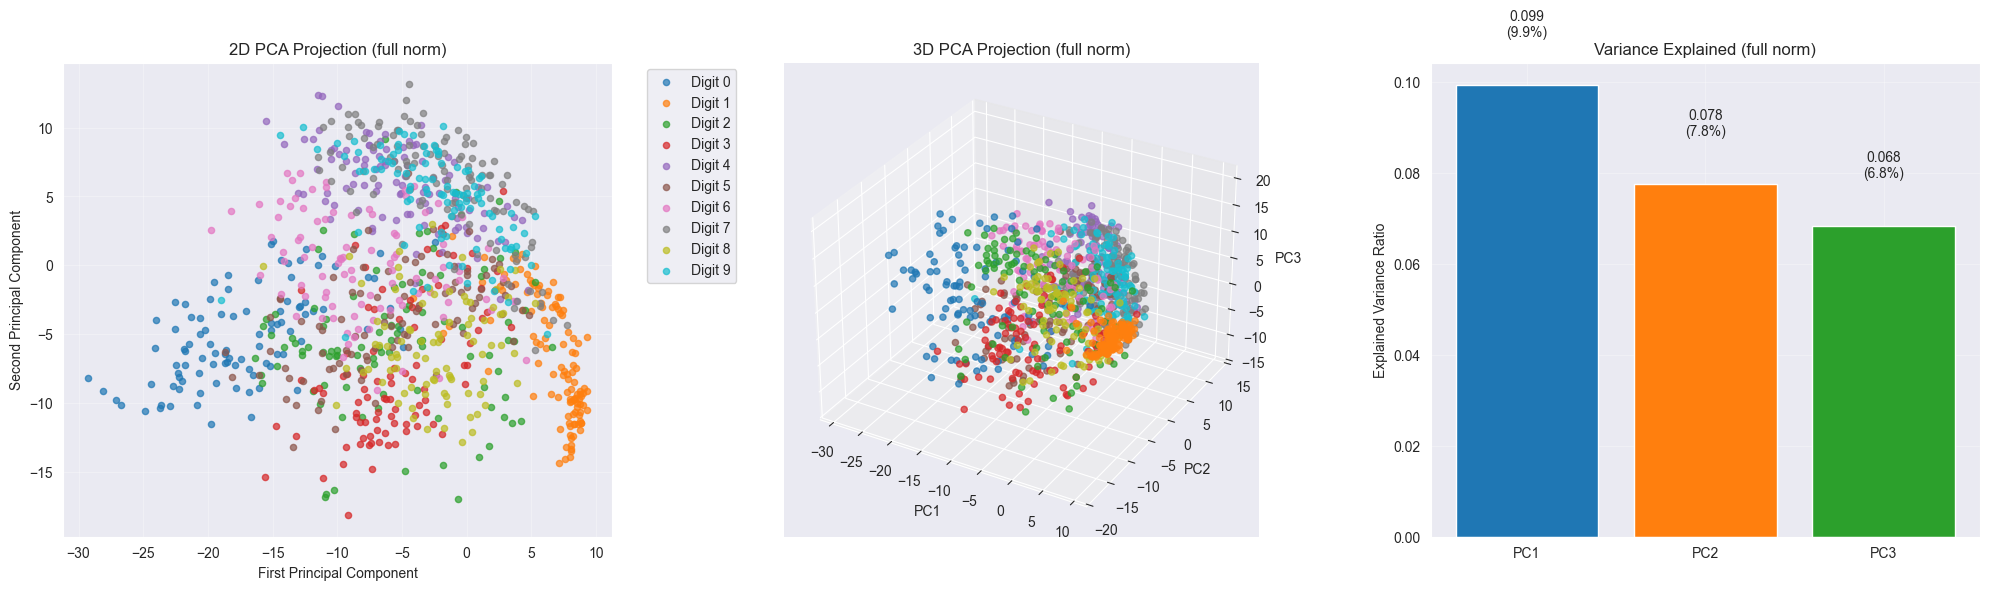

High-Dimensional Data Visualization (full normalization):
Original data shape: (1000, 784)
Reduced to 2D: (1000, 2)
Reduced to 3D: (1000, 3)

Variance explained by first 2 components: 0.177 (17.7%)
Variance explained by first 3 components: 0.245 (24.5%)

Normalization stats:
  Global mean: 32.701
  Global std: 77.810

=== COLUMN NORMALIZATION ===


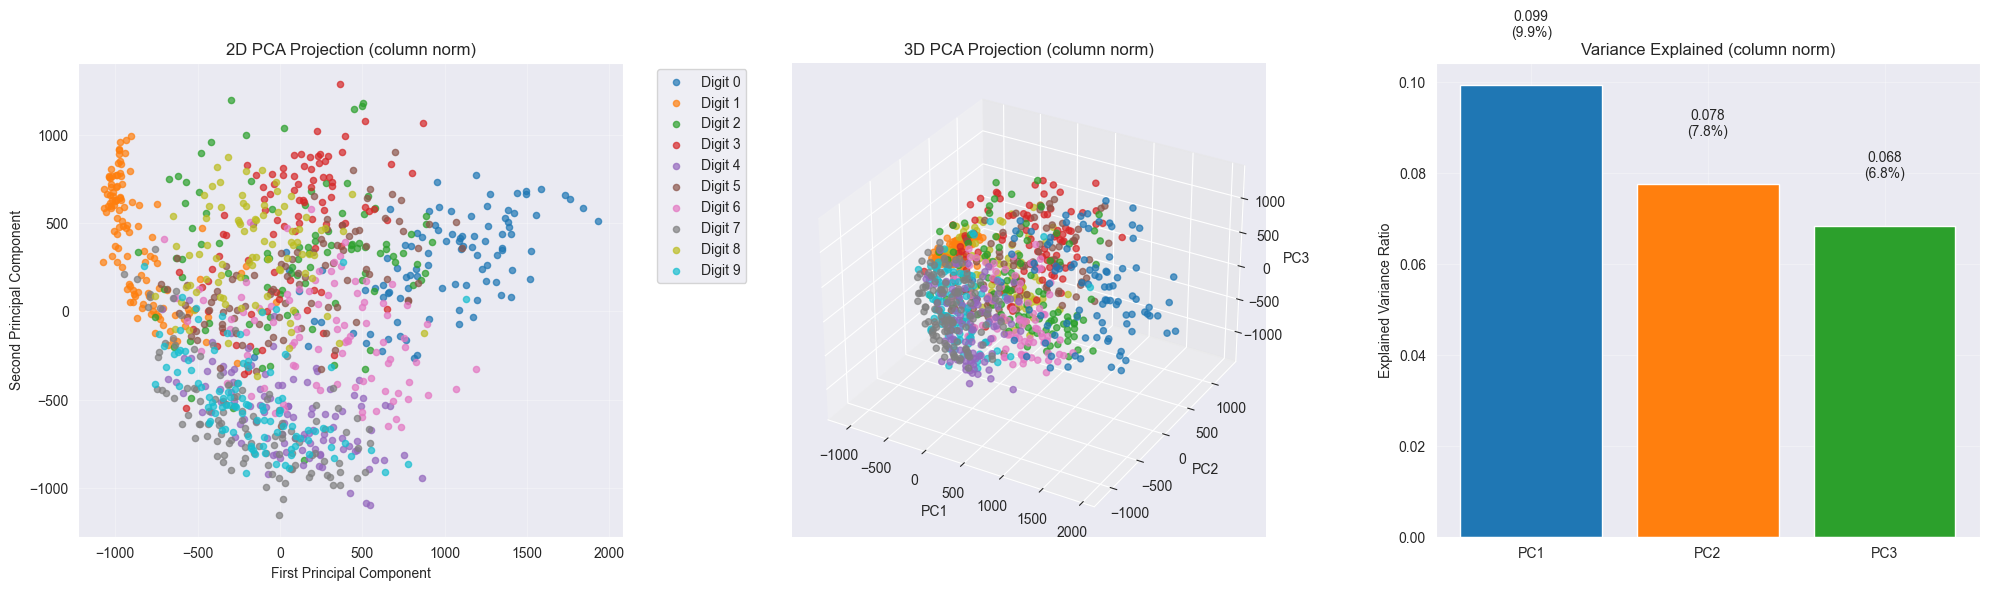

High-Dimensional Data Visualization (column normalization):
Original data shape: (1000, 784)
Reduced to 2D: (1000, 2)
Reduced to 3D: (1000, 3)

Variance explained by first 2 components: 0.177 (17.7%)
Variance explained by first 3 components: 0.245 (24.5%)


In [8]:
import numpy as np
import matplotlib.pyplot as plt


def create_high_dimensional_scatter_plot(normalization='column'):
    """
    Create scatter plots of high dimensional data using PCA for dimensionality reduction
    """
    sample_size = 1000
    X_sample = np.array([img.flatten() for img in x_train[:sample_size]])
    y_sample = np.array(y_train[:sample_size])
    
    pca_2d = PCAFromScratch(n_components=2, normalization=normalization)
    X_2d = pca_2d.fit_transform(X_sample)
    
    pca_3d = PCAFromScratch(n_components=3, normalization=normalization)
    X_3d = pca_3d.fit_transform(X_sample)
    
    fig = plt.figure(figsize=(20, 6))
    
    # 2D scatter plot
    ax1 = fig.add_subplot(131)
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    for i in range(10):
        mask = y_sample == i
        ax1.scatter(X_2d[mask, 0], X_2d[mask, 1], c=[colors[i]], label=f'Digit {i}', alpha=0.7, s=20)
    
    ax1.set_xlabel(f'First Principal Component')
    ax1.set_ylabel(f'Second Principal Component')
    ax1.set_title(f'2D PCA Projection ({normalization} norm)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # 3D scatter plot
    ax2 = fig.add_subplot(132, projection='3d')
    for i in range(10):
        mask = y_sample == i
        ax2.scatter(X_3d[mask, 0], X_3d[mask, 1], X_3d[mask, 2], c=[colors[i]], label=f'Digit {i}', alpha=0.7, s=20)
    
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('PC3')
    ax2.set_title(f'3D PCA Projection ({normalization} norm)')
    
    ax3 = fig.add_subplot(133)
    variance_ratios_2d = pca_2d.explained_variance_ratio_
    variance_ratios_3d = pca_3d.explained_variance_ratio_
    
    components = ['PC1', 'PC2', 'PC3']
    variances = [variance_ratios_3d[0], variance_ratios_3d[1], variance_ratios_3d[2]]
    
    bars = ax3.bar(components, variances, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax3.set_ylabel('Explained Variance Ratio')
    ax3.set_title(f'Variance Explained ({normalization} norm)')
    ax3.grid(True, alpha=0.3)
    
    for bar, var in zip(bars, variances):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{var:.3f}\n({var*100:.1f}%)', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"High-Dimensional Data Visualization ({normalization} normalization):")
    print("=" * 60)
    print(f"Original data shape: {X_sample.shape}")
    print(f"Reduced to 2D: {X_2d.shape}")
    print(f"Reduced to 3D: {X_3d.shape}")
    print(f"\nVariance explained by first 2 components: {np.sum(variance_ratios_2d):.3f} ({np.sum(variance_ratios_2d)*100:.1f}%)")
    print(f"Variance explained by first 3 components: {np.sum(variance_ratios_3d):.3f} ({np.sum(variance_ratios_3d)*100:.1f}%)")
    
    if normalization == 'full':
        print(f"\nNormalization stats:")
        print(f"  Global mean: {pca_2d.global_mean_:.3f}")
        print(f"  Global std: {pca_2d.global_std_:.3f}")
    
    return X_2d, X_3d, pca_2d, pca_3d

print("=== FULL NORMALIZATION ===")
X_2d_full, X_3d_full, pca_2d_full, pca_3d_full = create_high_dimensional_scatter_plot('full')

print("\n=== COLUMN NORMALIZATION ===")
X_2d_col, X_3d_col, pca_2d_col, pca_3d_col = create_high_dimensional_scatter_plot('column')